# Prediction de la présence en utilisant un réseau de neurones

Ce notebook a comme but de montrer ce qu'un réesau de neurones artificiels peut faire face à notre problème.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.metrics import FalseNegatives, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1

## Préparation des données

In [2]:
data = pd.read_csv("data/swiss_data_all_with_temp.csv")
df_presence = pd.read_csv("processed_data/df_berce_clean.csv")

In [3]:
# Create GeoDataFrame for presence data
geometry = [
    Point(xy)
    for xy in zip(df_presence["decimalLongitude"], df_presence["decimalLatitude"])
]
gdf_presence = gpd.GeoDataFrame(df_presence, geometry=geometry, crs="EPSG:4326")

# Transform to Swiss coordinate reference system (EPSG:2056)
gdf_presence = gdf_presence.to_crs(epsg=2056)

# Create GeoDataFrame for the Swiss dataset with presence/absence information
gdf = gpd.GeoDataFrame(data, geometry=gpd.GeoSeries.from_wkt(data["geometry"]))

# Initialize 'Presence'
gdf["Presence"] = 0

# Update 'Presence' based on the presence of points in the zone
for i, zone in gdf.iterrows():
    points_in_zone = gdf_presence[gdf_presence.geometry.within(zone.geometry)]
    if len(points_in_zone) > 0:
        gdf.at[i, "Presence"] = 1

In [4]:
# Separate the features and target
X = gdf.drop(
    columns=["Presence", "geometry", "idx", "Bodentyp"]
)  # Drop non-feature columns
y = gdf["Presence"].to_numpy()

# Normalize the bootstrapped features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Création du modèle

In [5]:
def init_model():
    model = Sequential(
        [
            Input(shape=(X_scaled.shape[1],)),
            Dense(8, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        optimizer="Adam",
        loss="MSE",
        metrics=[
            Recall(),
            FalseNegatives(),
        ],
    )
    return model

## Évaluation du modèle

In [6]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Store metrics for each fold
fold_metrics = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(y_train), y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))

    model = init_model()

    # Train the model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        class_weight=class_weight_dict,
        verbose=0,
    )

    # Evaluate on test set
    y_pred_proba = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fold_metrics.append(
        {"roc_auc": roc_auc, "precision": precision, "recall": recall, "f1": f1}
    )

# Display average performance
print("Cross-Validation Results:")
print(pd.DataFrame(fold_metrics).mean())

Cross-Validation Results:
roc_auc      0.767892
precision    0.146347
recall       0.756373
f1           0.245033
dtype: float64


In [7]:
# Predict probabilities for the entire dataset
gdf["predicted_proba"] = model.predict(scaler.transform(X), verbose=0).flatten()

In [8]:
def visualize_predictions(gdf, predicted_col="predicted_proba", threshold=0.5):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Probabilities
    gdf.plot(column=predicted_col, cmap="YlGnBu", legend=True, ax=ax[0], scheme="quantiles")

    ax[0].set_title("Predicted Probabilities", fontsize=14)
    ax[0].set_axis_off()

    # Binary classification map
    gdf["binary_pred"] = (gdf[predicted_col] >= threshold).astype(int)

    gdf.plot(column="binary_pred", cmap="seismic", legend=True, ax=ax[1], categorical=True)
    
    ax[1].set_title(f"Binary Classification (Threshold = {threshold})", fontsize=14)
    ax[1].set_axis_off()
    
    plt.show()

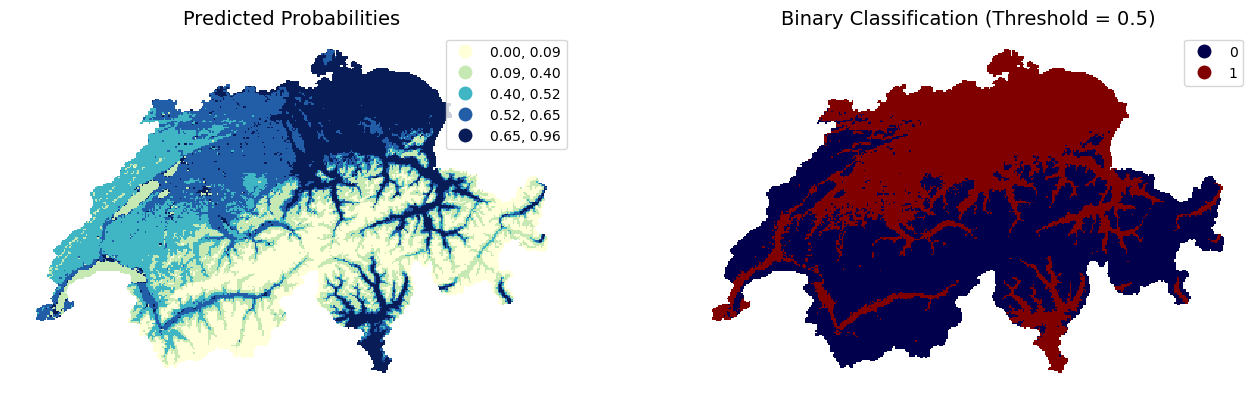

In [9]:
visualize_predictions(gdf)

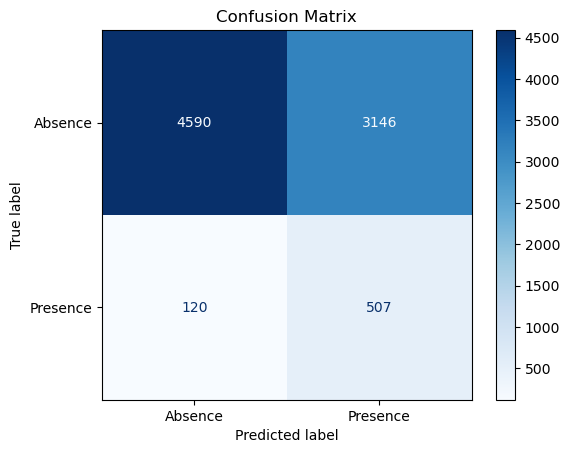

In [10]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Absence", "Presence"]
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()